# Max Bot Pipeline

In [29]:
%matplotlib inline
import pandas as pd
import codecs
import numpy as np
import re
import spacy

from maxbot.sensors.nlu.cleaning import NLCleaner
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from pprint import pprint

In [30]:
intents = pd.read_csv('data/intents.csv', 
                      names=['PHRASE', 'INTENT'])
intents.head()

,PHRASE,INTENT
0,Faltan mis 20 días por año,20dias
1,Calcular 20 días año,20dias
2,¿ pago 20 días por año?,20dias
3,Faltan 20 días,20dias
4,¿Y mis 20 días por año?,20dias


In [2]:
cleaner = NLCleaner()
cleaner.stopw_regex

re.compile(r'((\*)|(¿)|(\?)|(!)|(¡)|(-)|(\_)|(\.)|(:)|(;)|(\,)|(\{)|(\})|(\ba\b)|(\\)|(\/)|(\#)|(\")|(\')|(\()|(\))|(\bante\b)|(\bbajo\b)|(\bcabe\b)|(\bcon\b)|(\bcontra\b)|(\bde\b)|(\bdesde\b)|(\bpara\b)|(\bpor\b)|(\bsegún\b)|(\bsolo\b)|(\bhasta\b)|(\bel\b)|(\bla\b)|(\blos\b)|(\blas\b)|(\bmi\b)|(\bsu\b)|(\bnuestro\b)|(\bsuyo\b)|(\bsuya\b)|(\bsuyos\b)|(\bsuyas\b)|(\by\b)|(\bo\b)|(\bu\b))',
re.UNICODE)

## Corpus-based intent detector

In [3]:
VECTORIZER = TfidfVectorizer(analyzer='char',
                            #stop_words=cleaner.stopwords,
                            #strip_accents='ascii',
                            ngram_range=(1, 5))

In [175]:
whole_corpus = []
for intent in set(intents.INTENT):
    doc = ' '.join(intents.PHRASE[intents.INTENT == intent])
    doc = cleaner.remove_stopwords_text(doc)
    whole_corpus.append([intent, doc])
    
whole_corpus = pd.DataFrame(whole_corpus, 
                            columns=['INTENT', 'DOC'])
whole_corpus.tail(5)

,INTENT,DOC
32,Asesoria,en que temas me puedes asesorar me puedes ases...
33,RepartoUtilidades,utilidades cuanto me deben pagar reparto utili...
34,Despido_injustificado,despido injustiicado hablame sobre despido inj...
35,Felicitaciones,congratulations felicidades muy bien
36,Descanso,que pasa 1 primero mayo 1o mayo se trabaja 1 m...


In [176]:
query = pd.DataFrame([['TBD', 'me puedes decir mi finiquito']],
                     columns=['INTENT', 'DOC'])
whole_corpus = whole_corpus.append(query)
whole_corpus.tail(5)

,INTENT,DOC
33,RepartoUtilidades,utilidades cuanto me deben pagar reparto utili...
34,Despido_injustificado,despido injustiicado hablame sobre despido inj...
35,Felicitaciones,congratulations felicidades muy bien
36,Descanso,que pasa 1 primero mayo 1o mayo se trabaja 1 m...
0,TBD,me puedes decir mi finiquito


In [177]:
tfidfs = VECTORIZER.fit_transform(whole_corpus.DOC)
tfidfs.shape

(38, 5116)

In [207]:
query_tfidf = tfidfs[-1, :]
comps = []
for i, vect in enumerate(tfidfs[:-1, :]):
    score = cosine_similarity(query_tfidf, vect).squeeze()
    comps.append([whole_corpus.INTENT[:-1][i], score])
comps = pd.DataFrame(index=[i[0] for i in comps],
                     data={'SCORE': [i[1] for i in comps]})
comps

,SCORE
derecho-civil,0.13389872542392045
derecho-de-protección-de-datos,0.023073262844865126
Pregunta_de_aguinaldo,0.05759208858500174
NoDespedido,0.15092854666429312
Comisiones,0.09312760296020209
derecho-mercantil,0.07727380263617256
Día,0.08644722400431328
Creación,0.10926867012319103
derecho-familiar,0.1286599159418947
chiste,0.12144336282225268


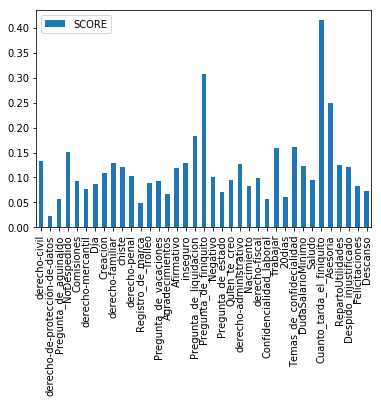

In [210]:
comps.astype(float).plot(kind='bar')

In [217]:
print(intents[intents.INTENT == 'Pregunta_de_finiquito'])
print(intents[intents.INTENT == 'Cuanto_tarda_el_finiquito'])
query

                          PHRASE                 INTENT
136  ¿ puedo calcular finiquito?  Pregunta_de_finiquito
137       ¿Cuanto toca renuncia?  Pregunta_de_finiquito
138           Pagar de finiquito  Pregunta_de_finiquito
139           Calcular finiquito  Pregunta_de_finiquito
140            calcular renuncia  Pregunta_de_finiquito
141       renunciar cuánto pagar  Pregunta_de_finiquito
142                     Renuncia  Pregunta_de_finiquito
143                    Finiquito  Pregunta_de_finiquito
144             Quiero renunciar  Pregunta_de_finiquito
                                  PHRASE                     INTENT
46  En cuanto tiempo me dan mi finiquito  Cuanto_tarda_el_finiquito
47          Cuando me llega mi finiquito  Cuanto_tarda_el_finiquito
48  Cunto tengo que esperar mi finiquito  Cuanto_tarda_el_finiquito
49  Cuando tiene que llegar mi finiquito  Cuanto_tarda_el_finiquito
50             Cuanto tarda mi finiquito  Cuanto_tarda_el_finiquito


,INTENT,DOC
0,TBD,me puedes decir mi finiquito


## Data augmentation

In [15]:
import spacy
nlp = spacy.load('es')

In [16]:
doc = nlp("por su pollo")
print(' '.join([token.lemma_ for token in doc]))
for token in doc:
    print(token, token.lemma, token.lemma_)

por su pollo
por 18244196334509357400 por
su 14248009254309298022 su
pollo 16073858462310522486 pollo


In [20]:
# Data augmentation
aug_corpus = []
for intent in set(intents.INTENT):
    orig = ' '.join(intents.PHRASE[intents.INTENT == intent])
    doc = nlp(orig)
    augmented = orig + ' ' + ' '.join([' ' + token.lemma_ for token in doc])
    augmented = cleaner.remove_stopwords_text(augmented)
    aug_corpus.append([intent, augmented])
    
aug_corpus = pd.DataFrame(aug_corpus, 
                          columns=['INTENT', 'DOC'])
aug_corpus.tail(5)

,INTENT,DOC
32,Quien_te_creo,como te hicieron como te programaron quiin te ...
33,Temas_de_confidecialidad,me puedes habalar sobre temas confidencialidad...
34,derecho-mercantil,compañia seguros no quiere reembolsar asegurad...
35,Agradecimientos,te lo agradezco gracias muchas gracias muchisi...
36,inseguro,creo que fue creo que fue en no lo si no lo re...


In [21]:
# Add query to intent frame
query = pd.DataFrame([['TBD', 'por su pollo']],
                     columns=['INTENT', 'DOC'])
aug_corpus = aug_corpus.append(query)
aug_corpus.tail(5)

,INTENT,DOC
33,Temas_de_confidecialidad,me puedes habalar sobre temas confidencialidad...
34,derecho-mercantil,compañia seguros no quiere reembolsar asegurad...
35,Agradecimientos,te lo agradezco gracias muchas gracias muchisi...
36,inseguro,creo que fue creo que fue en no lo si no lo re...
0,TBD,por su pollo


In [22]:
# Compute TF-IDF scores
tfidfs = VECTORIZER.fit_transform(aug_corpus.DOC)
max_features = len(max(aug_corpus.DOC, key=len))
tfidfs.shape, max_features

((38, 6143), 856)

In [23]:
# Compute cosine similarity scores
query_tfidf = tfidfs[-1, :]
comps = []
for i, vect in enumerate(tfidfs[:-1, :]):
    score = cosine_similarity(query_tfidf, vect).squeeze()
    comps.append([aug_corpus.INTENT[:-1][i], score])
comps = pd.DataFrame(index=[i[0] for i in comps],
                     data={'SCORE': [i[1] for i in comps]})
comps.SCORE = comps.SCORE/sum(comps.SCORE)
comps

,SCORE
derecho-fiscal,0.0193011
chiste,0.0222018
Negativo,0.0511954
derecho-civil,0.0402199
derecho-penal,0.0403789
Pregunta_de_estado,0.0251846
Confidencialidad_laboral,0.0135944
Pregunta_de_liquidacion,0.0337523
Día,0.0225261
Trabajar,0.0371766


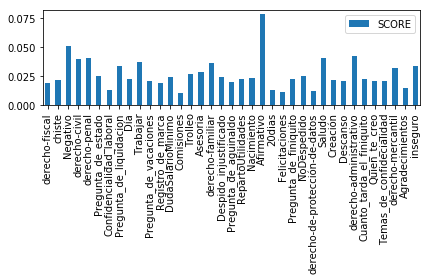

In [24]:
ax = comps.astype(float).plot(kind='bar')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig('scores.png')
ax

In [25]:
comps.index[comps.SCORE == max(comps.SCORE)][0]

'Afirmativo'

## Word classification testing

In [38]:
from maxbot.sensors.nlu.parsing import NLParser, VECTORIZER
from pattern.es import conjugate as conjugate_es

In [25]:
parser = NLParser(intent_data='data/intents.csv')

Augmenting intent internal representation...
DONE


In [39]:
def process(phrase):
    doc = parser.nlp(phrase.lower())
    processed = []
    for token in doc:
        if token.pos_ == 'VERB':
            word = conjugate_es(str(token.lemma_), tense='future')
            if word:
                processed.append(word)
        else:
            processed.append(token.lemma_)
    return ' '.join(processed)
intents.PHRASE.apply(process)

0                              faltará mi 20 día por año
1                                   calculará 20 día año
2                             ¿ pagar   20 día por año ?
3                                       faltará   20 día
4                                ¿ y mi 20 día por año ?
5                                           por su pollo
6                                                porfará
7                                                    oká
8                                                 awiwiá
9                                                    eyá
10                                               ahuevar
11                                                 simón
12                                            afirmativo
13                                              correcto
14                                          ser correcto
15                                          por su poner
16                                              asir ser
17                             

In [27]:
parser.intents

,DOC,REGEX
derecho-fiscal,me llego un requerimiento del hacienda me ll...,re.compile('(\\bllego requerimiento hacienda\\...
20dias,faltan mis 20 dias año calcular 20 dias año pa...,re.compile('(\\bfaltan dias año\\b)|(\\bcalcul...
Afirmativo,pollo porfa ok awiwi ey ahuevo simon afirmativ...,re.compile('(\\bpor su pollo\\b)|(\\bporfa\\b)...
Agradecimientos,te lo agradezco gracias muchas gracias muchisi...,re.compile('(\\bte lo agradezco\\b)|(\\bgracia...
Asesoria,en que temas me puedes asesorar me puedes ases...,re.compile('(\\btemas asesorar\\b)|(\\bme pued...
derecho-penal,clonaron tarjeta robaron casa asesinaron espos...,re.compile('(\\bclonaron tarjeta\\b)|(\\brobar...
Pregunta_Constitucion_Sociedad,como puedo constituir una sociedad como puedo ...,re.compile('(\\bconstituir sociedad\\b)|(\\bcr...
Saludo,que hongo ayudame quiubo max saludos aloh holi...,re.compile('(\\bque hongo\\b)|(\\bayudame\\b)|...
Quien_te_creo,como te hicieron como te programaron quien te ...,re.compile('(\\bcomo te hicieron\\b)|(\\bcomo ...
Una_persona,una 1 uno 1,re.compile('(\\buna\\b)|(\\b1\\b)')


In [7]:
results.head()

,PHRASE,INTENT,RESULT,SCORE
0,Faltan mis 20 días por año,20dias,20dias,0.193422
1,Calcular 20 días año,20dias,20dias,0.191411
2,¿ pago 20 días por año?,20dias,20dias,0.209875
3,Faltan 20 días,20dias,20dias,1.000000
4,¿Y mis 20 días por año?,20dias,20dias,0.227838


In [8]:
results[results.INTENT != results.RESULT]

,PHRASE,INTENT,RESULT,SCORE
42,¿Quién te hizo?,Creación,Quien_te_creo,0.149904
59,esta tarjeta ha sido clonada,derecho-civil,derecho-de-protección-de-datos,0.118792
99,No estoy seguro,inseguro,derecho-mercantil,0.083287
114,por supuesto que no,Negativo,inseguro,0.075921
140,"¡Dime mi finiquito, Max!",Pregunta_de_finiquito,Cuanto_tarda_el_finiquito,0.133431
175,¿Quién te creó?,Quien_te_creo,Creación,0.136462


In [39]:
commands = ['Pregunta_de_vacaciones', 
            'chiste', 
            'Pregunta_de_estado',
            'derecho-penal']
for c in commands:
    _, score = parser.cosine_parse('deseo registrar mi marca', 
                                   parser._slice_intents([c, 'chiste']))
    print(parser._slice_intents([c]).DOC)
    print(c, score)

Pregunta_de_vacaciones    cuantos dias tocan vacaciones vacaciones cuant...
Name: DOC, dtype: object
Pregunta_de_vacaciones 0.588768709991
chiste    cuentame un chiste jaja estoy aburrido estoy d...
Name: DOC, dtype: object
chiste 0.5
Pregunta_de_estado    como estas como estas max como te va max como ...
Name: DOC, dtype: object
Pregunta_de_estado 0.565912897178
derecho-penal    clonaron tarjeta robaron casa asesinaron espos...
Name: DOC, dtype: object
derecho-penal 0.522086486862


In [59]:
key = parser._slice_intents(['Pregunta_de_estado']).DOC.values[0]
print(key)
query = 'como te va max'
tfidfs = VECTORIZER.fit_transform([key, query])
cosine_similarity(tfidfs[0, :], tfidfs[1, :]).squeeze()

como estas como estas max como te va max como te va como has estado que tal te va max como va tu dia max como va tu dia  comer  este  comer  este  max  comer  te  ir  max  comer  te  ir  comer  haber  estar  que  tal  te  ir  max  comer  ir  tu  dia  max  comer  ir  tu  dia


array(0.6154849864992277)

In [68]:
getattr(events, 'registro_marca_13')

<function maxbot.structures.fem.events.registro_marca_13>

In [87]:
for _, row in aug_corpus.iterrows():
    doc = nlp(row.DOC)
    i = 0
    j = 0
    trim = []
    for token in doc:
        if token.pos_ in ['VERB', 'NOUN', 'ADJ', 'ADP','ADV']:
            trim.append(str(token))
            i += 1
        j += 1
    print(' '.join(trim))
    print(i, j, row.INTENT)

cuentame chiste jaja aburrido deprimido ya dime cosa dime chiste quiero reir cuentame chistar jaja aburrir deprimir ya dime coser dime chistar reir
23 38 chiste
agradezco gracias gracias muchisimas gracias grax agradezco ohhh gracias max mejor agradecer gracias gracia muchisimas gracia agradecer ohhh gracias max mejor
21 31 Agradecimientos
llego requerimiento del hacienda llegar requerimiento del hacendar
8 12 derecho-fiscal
max va max va qui va max va dia max va dia max ir max qui ir max ir dia max ir dia
23 58 Pregunta_de_estado
despido injustiicado hablame sobre despido injustficado jefe corrio sin motivo despido sin motivo rason despido injustiicado hablame sobrar despedir injustficado jefe corrio sin motivar despido sin motivar ni rason
29 32 Despido_injustificado
fecha hoy qui dia semana hoy qui dia hoy qui hoy dia semana hoy fecho hoy qui semana hoy dia hoy qui estar hoy dia semana hoy
27 45 Día
registrar logo registro marca logo registrar slogan slogan registrar marca registrar

In [101]:
keys = ['derecho-mercantil', 'Descanso', 'Trolleo', 'derecho-penal']
sliced = []
for k in keys:
    sliced.append([k, aug_corpus.DOC[aug_corpus.INTENT == k]])
sliced = pd.DataFrame(sliced, columns=aug_corpus.keys())
sliced

,INTENT,DOC
0,derecho-mercantil,17 compañia seguros no quiere reembolsar as...
1,Descanso,15 que pasa 1 primero mayo 1o mayo se traba...
2,Trolleo,14 joder coño saca caguamas me amas tienes ...


In [105]:
sliced['lel'] = pd.Series([1, 2, 3])
sliced

,INTENT,DOC,lel
0,derecho-mercantil,17 compañia seguros no quiere reembolsar as...,1
1,Descanso,15 que pasa 1 primero mayo 1o mayo se traba...,2
2,Trolleo,14 joder coño saca caguamas me amas tienes ...,3


In [18]:
import pandas as pd
from maxbot.sensors.nlu.parsing import NLParser

In [19]:
parser = NLParser(intent_data='data/intents.csv')

Augmenting intent internal representation...
DONE


In [23]:
parser.intents

,DOC,REGEX
Descanso,que pasa 1 primero mayo 1o mayo se trabaja 1 m...,re.compile('(\\bpasa primero mayo\\b)|(\\b1o m...
Una_persona,una 1 uno 1,re.compile('(\\buna\\b)|(\\b1\\b)')
Trabajar_empresa,empresa empresa empresa empresa,re.compile('(\\bpor empresa\\b)|(\\bempresa\\b)')
Día,cual es fecha hoy que dia semana es hoy que di...,re.compile('(\\bfecha\\b)|(\\bdia semana\\b)|(...
20dias,faltan mis 20 dias año calcular 20 dias año pa...,re.compile('(\\bfaltan dias año\\b)|(\\bcalcul...
Pregunta_Constitucion_Sociedad,como puedo constituir una sociedad como puedo ...,re.compile('(\\bconstituir sociedad\\b)|(\\bcr...
Pregunta_de_estado,como estas como estas max como te va max como ...,re.compile('(\\bcomo estas\\b)|(\\bcomo estas ...
derecho-mercantil,compañia seguros no quiere reembolsar asegurad...,re.compile('(\\bcompañia seguros quiere reembo...
NoDespedido,en realidad aun no me despiden creo que estoy ...,re.compile('(\\brealidad despiden\\b)|(\\bcreo...
derecho-familiar,quiero divorciar tacaño marido no me ha pagado...,re.compile('(\\bquiero divorciar\\b)|(\\btacañ...


In [4]:
key = ['Negativo', 'Afirmativo', 'Despido_injustificado', 'Pregunta_de_liquidacion']
arcs = parser._slice_intents(key)
for index, regex in arcs.REGEX.iteritems():
    print(index, regex)

Negativo re.compile('(\\bno\\b)|(\\bpara nada\\b)|(\\bnegativo\\b)|(\\bes incorrecto\\b)|(\\bincorrecto\\b)|(\\berror\\b)|(\\bpor supuesto no\\b)|(\\bnel\\b)|(\\bnel pastel\\b)|(\\bnelson\\b)|(\\bno\\b)|(\\bnadar\\b)|(\\)
Afirmativo re.compile('(\\bpor su pollo\\b)|(\\bporfa\\b)|(\\bok\\b)|(\\bawiwi\\b)|(\\bey\\b)|(\\bahuevo\\b)|(\\bsimon\\b)|(\\bafirmativo\\b)|(\\bcorrecto\\b)|(\\bes correcto\\b)|(\\bpor su puesto\\b)|(\\basi es\\b)|(\\bco)
Despido_injustificado re.compile('(\\bdespido injustiicado\\b)|(\\bhablame sobre despido injustficado\\b)|(\\bjefe corrio sin motivo\\b)|(\\bdespido sin motivo rason\\b)|(\\bdespedir\\b)|(\\binjustiicado\\b)|(\\bhablame\\b)|(\\bsobra)
Pregunta_de_liquidacion re.compile('(\\bcon novedad de puto jefe va a mandar alv\\b)|(\\bliquidacion\\b)|(\\bquiero toca de liquidacion\\b)|(\\bdespido\\b)|(\\btendrian pagar\\b)|(\\bcalcular liquidacion\\b)|(\\bme van despedir\\b)|(\\)


In [8]:
query = 'me quiero divorciar'
decision, score = parser.intent_parse(query, list(parser.intents.index))
decision, score

Attempting regex parse...
Regex parse not successful!!
Attempting cosine parse...


('derecho-familiar', 0.061004448800570509)

## Regex parsing

In [36]:
import re

In [47]:
for match in re.finditer('(\d{2})\d{2}', 'del 4 de nov de 1967 al 20 de agosto de 2009'):
    print(match.group())

1967
2009


In [58]:
re.sub('[^\w\s]', ' ', 'del 4 de nov de 1967;, al 20-ago- 2009.').split()

['del', '4', 'de', 'nov', 'de', '1967', 'al', '20', 'ago', '2009']

In [153]:
from maxbot.sensors.nlu.parsing import NLParser, VECTORIZER, cosine_similarity, CLEANER

parser = NLParser('data/intents.csv')

Augmenting intent internal representation...
DONE


In [8]:
parser.intents.index

Index(['DudaSalarioMinimo', 'Una_persona', 'Cuanto_tarda_el_finiquito',
       'Pregunta_de_liquidacion', 'Trabajar_empresa',
       'derecho-de-protección-de-datos', 'Comisiones', 'Registro_de_marca',
       'derecho-civil', 'derecho-fiscal', 'Día', 'Afirmativo', 'derecho-penal',
       'Negativo', 'Trolleo', 'Mas_de_una_persona', 'Inseguro', 'Tener_duda',
       'Confidencialidad_laboral', 'Asesoria', 'Pregunta_de_finiquito',
       'Nacimiento', 'chiste', 'NoDespedido', 'Despido_injustificado',
       'Trabajar_outsourcing', 'Pregunta_de_vacaciones',
       'Pregunta_de_aguinaldo', 'Agradecimientos', 'Pregunta_de_estado',
       'RepartoUtilidades', 'Creación', 'derecho-familiar', 'Quien_te_creo',
       '20dias', 'derecho-administrativo', 'derecho-mercantil', 'Descanso',
       'Temas_de_confidecialidad', 'Felicitaciones', 'Saludo', 'Trabajar'],
      dtype='object')

In [154]:
targets = ['Registro_de_marca',
           'Pregunta_de_liquidacion', 
           'Pregunta_de_finiquito',
           'Pregunta_de_aguinaldo', 'chiste']
parser.intent_parse('pues mi jefe me retiró la computadora ayer y hoy me dieron de baja de la cuenta de correos',
                    ['chiste'], serialize=True)

array(0.5067775085708154)

In [166]:
query = 'pues mi jefe me retiró la computadora ayer y hoy me dieron de baja de la cuenta de correos'
key = 'chiste'
examples = ' '.join(parser.intents.DOC[parser.intents.index == key])
char_vect = TfidfVectorizer(analyzer='char',
                            tokenizer=CLEANER.remove_stopwords_text,
                            ngram_range=(2, 5))
tfidfs = char_vect.fit_transform([examples, query])
cosine_similarity(tfidfs[0, :], tfidfs[1, :]).squeeze()

array(0.1763636405782468)

In [167]:
#query = 'Ay ya cuéname otra cosa... un chiste!!!'
for index, row in intents.iterrows():
    query = row.PHRASE
    key = 'chiste'
    examples = ' '.join(parser.intents.DOC[parser.intents.index == key])
    compl = ' '.join(parser.intents.DOC[parser.intents.index != key])
    tfidfs = char_vect.fit_transform([compl, examples, query])
    query_tfidf = tfidfs[-1, :]
    res = []
    for i, vect in enumerate(tfidfs[:-1, :]):
        res.append(cosine_similarity(query_tfidf, vect).squeeze())
    #score = parser.intent_parse(query, [key])
    #if isinstance(score, tuple):
    #    score = score[1]
    if np.abs(res[0] - res[1]).squeeze() >= 0.2: 
        print(query,
              res[1] - res[0],
              row.INTENT)

jaja 0.353096227414 chiste
jajajajajajaja 0.43228670878 chiste
jejejejeje 0.248810649128 chiste
jijijijiji 0.273362186428 chiste
En cuanto tiempo me dan mi finiquito -0.241467522466 Cuanto_tarda_el_finiquito
Cunto tengo que esperar mi finiquito -0.259041215461 Cuanto_tarda_el_finiquito
Cuando tiene que llegar mi finiquito -0.240408490689 Cuanto_tarda_el_finiquito
Cuanto tarda mi finiquito -0.20573945357 Cuanto_tarda_el_finiquito
quiero cobrar un pagaré de una persona que no me ha pagado -0.225092273248 derecho-civil
¿Me puedes decir el finiquito que me toca? -0.207584672655 Pregunta_de_finiquito
renunciar cuánto pagar -0.20271894469 Pregunta_de_finiquito
Quiero saber cuánto me toca de liquidación -0.219955842285 Pregunta_de_liquidacion
¿Cuánto tienen pagar liquidación? -0.22927415372 Pregunta_de_liquidacion
cuánto me deben pagar por el reparto de utilidades -0.226173860518 RepartoUtilidades
si no me han pagado el reparto de utilidades, qué debo hacer -0.210868787564 RepartoUtilidades
M

In [169]:
def search_inline(text, key, low=0, up=None, verbose=False):
    CHAR_VEC = TfidfVectorizer(analyzer='char',
                               min_df=1,
                               ngram_range=(2, 4))
    lower = low
    if up is None:
        upper = len(key)
    else:
        upper = up
    res = []
    while upper < len(text):
        portion = text[lower: upper].lower()
        tfidf = CHAR_VEC.fit_transform([portion, key])
        sim = cosine_similarity(tfidf[0, :], tfidf[1, :]).squeeze()
        if verbose and sim:
            print(sim, portion)
        res.append((sim, (lower, upper), portion))
        lower += 1
        upper += 1
    return res

In [168]:
examples = ' '.join(parser.intents.DOC[parser.intents.index == 'chiste'])
examples

'cuentame un chiste jaja jajajajajajaja jejejejeje jijijijiji estoy aburrido estoy deprimido ay ya dime otra cosa dime un chiste me quiero reir  cuentame  uno  chistar  jaja  jajajajajajaja  jejejejeje  jijijijiji  estar  aburrir  estar  deprimir  ay  ya  dime  otro  coser  dime  uno  chistar  me  querer  reir'

In [178]:
query = 'jajaja un chiste porfi'
max(search_inline(examples, query), key=lambda tup: tup[0])

(array(0.6477453055230885), (8, 30), ' un chiste jaja jajaja')

## Pruebas de fórmulas de liquidación

In [40]:
from maxbot.utils.numeric_utils import get_indemnizacion, get_prima_vacacional, get_finiquito, dias_vacaciones
from maxbot.utils.numeric_utils import get_liquidacion, get_aguinaldo, get_prima_antiguedad, get_vacaciones
from maxbot.sensors.nlu.entities import parse_money, parse_date
from maxbot.utils.functions import date_to_string, money_to_string

import dateparser, datetime

In [41]:
ingreso = parse_date('24 de marzo 2010')
date_to_string(ingreso)

'24/03/2010'

In [42]:
baja = parse_date('08 de septiembre 2017')
date_to_string(baja)

'08/09/2017'

In [43]:
salario_mensual = parse_money('$12,350')
money_to_string(salario_mensual)

'$12,350.00 MXN'

In [44]:
salario_diario = salario_mensual / 30
money_to_string(salario_diario)

'$411.67 MXN'

In [45]:
# Aguinaldo
aguinaldo = get_aguinaldo(baja, salario_mensual)
money_to_string(aguinaldo)

'$4,219.62 MXN'

In [46]:
aniv = datetime.datetime(baja.year,
                         ingreso.month,
                         ingreso.day)
print(date_to_string(aniv), date_to_string(baja))
(baja - aniv).days

24/03/2017 08/09/2017


168

In [47]:
# Vacaciones
vacaciones = get_vacaciones(baja, ingreso, salario_mensual)
money_to_string(vacaciones)

days: 169
vac_days: 14
vacs_year: 0.04


'$2,782.89 MXN'

In [9]:
money_to_string(get_prima_antiguedad(baja, ingreso, salario_mensual))

'$15,841.18 MXN'

In [10]:
money_to_string(get_indemnizacion(baja, ingreso, salario_mensual))

'$37,507.50 MXN'

In [11]:
money_to_string(get_prima_vacacional(baja, ingreso, salario_mensual))

'$695.72 MXN'